## Stitch HCA_F_RepTsp13902013 & HCA_F_RepTsp13902014 (Uterovaginal canal)

In [9]:
import scanpy as sc

Nadav did a cool thing and stitched together a human limb of three separate Visium slides. He did all the image lifting:
- put together the three images into one
- the size factors were exactly the same (likely as the result of the same exact zoom being used when taking the slide pictures), so there was no need to mess with the source images on that axis
- once the images were put together, he corrected the underlying spot coordinates so they're all compatible

The files exist in three separate Visium mapping folders, with an extra `spatial_0` folder with the new stuff. And now we need to join them somehow!

We can't exactly just `sc.read_visium()` the thing as that specifically requires `.h5` formatted matrices. However, we can emulate the final outcome of `sc.read_visium()` by importing the three count matrices separately, merging them, and then adding the stitched together limb into the necessary spatial slots of the object. Start with the count matrices!

### 1. Import h5ad files per sample

In [10]:
HCA_F_RepTsp13902013 = sc.read_10x_h5("/nfs/team292/vl6/FetalReproductiveTract/VISIUM/data/HCA_F_RepTsp13902013/raw_feature_bc_matrix.h5")
HCA_F_RepTsp13902013.var_names_make_unique()
HCA_F_RepTsp13902014 = sc.read_10x_h5("/nfs/team292/vl6/FetalReproductiveTract/VISIUM/data/HCA_F_RepTsp13902014/raw_feature_bc_matrix.h5")
HCA_F_RepTsp13902014.var_names_make_unique()

/opt/conda/envs/imagespot/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/envs/imagespot/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [11]:
HCA_F_RepTsp13902013.obs_names = ["HCA_F_RepTsp13902013_"+i for i in HCA_F_RepTsp13902013.obs_names]
HCA_F_RepTsp13902013.obs["sample"] = "HCA_F_RepTsp13902013"
HCA_F_RepTsp13902014.obs_names = ["HCA_F_RepTsp13902014_"+i for i in HCA_F_RepTsp13902014.obs_names]
HCA_F_RepTsp13902014.obs["sample"] = "HCA_F_RepTsp13902014"

### 2. Concatenate anndata objects

In [12]:
adata = HCA_F_RepTsp13902013.concatenate(HCA_F_RepTsp13902014, index_unique=None)
adata

/opt/conda/envs/imagespot/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 9975 × 37082
    obs: 'sample', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

In [13]:
adata.uns["spatial"] = dict()
library_id = "joint"
adata.uns["spatial"][library_id] = dict()

In [14]:
from matplotlib.image import imread

adata.uns["spatial"][library_id]['images'] = dict()
adata.uns["spatial"][library_id]['images']["hires"] = imread("HCA_F_RepTsp13902013_14_tissue_hires_image.png")

### 3. Import the scale factors & tissue positions

In [15]:
import json

with open("/nfs/team292/vl6/FetalReproductiveTract/VISIUM/data/HCA_F_RepTsp13902013/spatial/scalefactors_json.json", "r") as fid:
    adata.uns["spatial"][library_id]['scalefactors'] = json.load(fid)

In [16]:
import pandas as pd

p1 = pd.read_csv("HCA_F_RepTsp13902013_tissue_positions_list.csv", header=None)
p2 = pd.read_csv("HCA_F_RepTsp13902014_tissue_positions_list.csv", header=None)

Name the columns appropriately and set the index. In the process also add the sample ID as a prefix to the barcodes so it matches the object.

In [17]:
p1.columns = [
    'barcode',
    'in_tissue',
    'array_row',
    'array_col',
    'pxl_col_in_fullres',
    'pxl_row_in_fullres',
]

p1.index = p1['barcode']

p2.columns = [
    'barcode',
    'in_tissue',
    'array_row',
    'array_col',
    'pxl_col_in_fullres',
    'pxl_row_in_fullres',
]

p2.index = p2['barcode']


In [18]:
p1.head()

,barcode,in_tissue,array_row,array_col,pxl_col_in_fullres,pxl_row_in_fullres
barcode,,,,,,
HCA_F_RepTsp13902013_GTCACTTCCTTCTAGA-1,HCA_F_RepTsp13902013_GTCACTTCCTTCTAGA-1,0,0,0,2506.350355,1717.074687
HCA_F_RepTsp13902013_CACGGTCTCCTTACGA-1,HCA_F_RepTsp13902013_CACGGTCTCCTTACGA-1,0,0,2,2473.375666,1718.366929
HCA_F_RepTsp13902013_ATAGCTGCGGATAAGA-1,HCA_F_RepTsp13902013_ATAGCTGCGGATAAGA-1,0,0,4,2440.400977,1719.659171
HCA_F_RepTsp13902013_GTCAGTATGTCCGGCG-1,HCA_F_RepTsp13902013_GTCAGTATGTCCGGCG-1,0,0,6,2406.826748,1720.974908
HCA_F_RepTsp13902013_ATGTACCAGTTACTCG-1,HCA_F_RepTsp13902013_ATGTACCAGTTACTCG-1,0,0,8,2373.875554,1722.866690


In [19]:
p1.shape

(4991, 6)

### 3. Read the overlapping barcodes and add as metadata

In [20]:
with open("HCA_F_RepTsp13902013_14_overlapping_barcodes.json", "r") as f:
    overlapping_barcodes = json.load(f)

In [21]:
len(list(overlapping_barcodes.keys()))

394

In [22]:
p1['overlaps_with'] = None

In [23]:
for i in p1.index:
    if i in list(overlapping_barcodes.keys()):
        p1.loc[i, 'overlaps_with'] = overlapping_barcodes[i]

In [24]:
overlapping_barcodes_reverse = {v: k for k, v in overlapping_barcodes.items()}

In [25]:
p2['overlaps_with'] = None

In [26]:
for i in p2.index:
    if i in list(overlapping_barcodes_reverse.keys()):
        p2.loc[i, 'overlaps_with'] = overlapping_barcodes_reverse[i]

Concatenate the positions files

In [27]:
positions = pd.concat([p1, p2])

In [28]:
import numpy as np

In [29]:
positions['is_overlap'] = np.where(positions['overlaps_with'].isna() == True, 0, 1)

In [30]:
positions['is_overlap'].value_counts(dropna = False)

0    9194
1     788
Name: is_overlap, dtype: int64

Absorb into the object.

In [31]:
adata.obs = adata.obs.join(positions, how="left")

adata.obsm['spatial'] = adata.obs[
    ['pxl_row_in_fullres', 'pxl_col_in_fullres']
].to_numpy()
adata.obs.drop(
    columns=['barcode', 'pxl_row_in_fullres', 'pxl_col_in_fullres'],
    inplace=True,
)

Plot the sample...

In [32]:
spatial = adata.obsm['spatial'].copy()
adata.obsm['spatial'][:,0] = spatial[:,1]
adata.obsm['spatial'][:,1] = spatial[:,0]

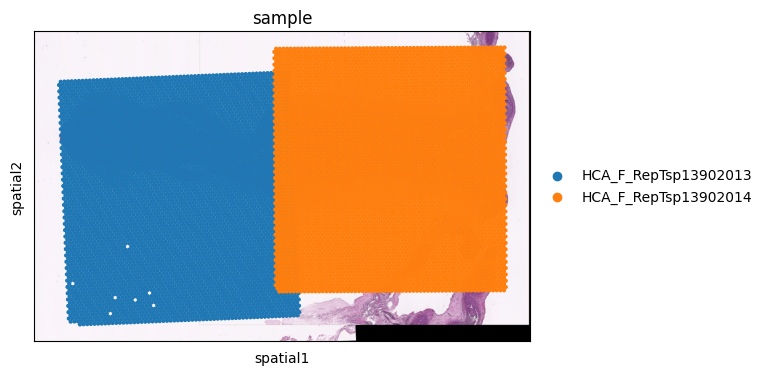

In [33]:
sc.pl.spatial(adata, color="sample")

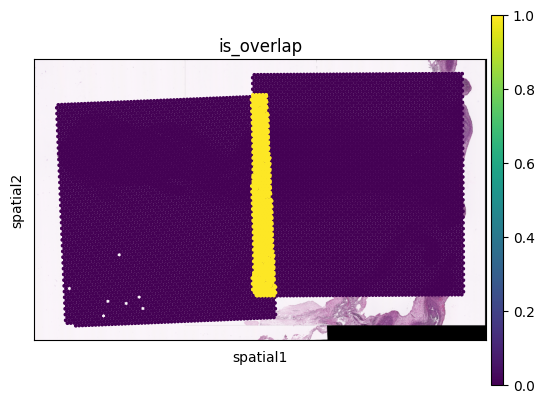

In [34]:
sc.pl.spatial(adata, color="is_overlap")

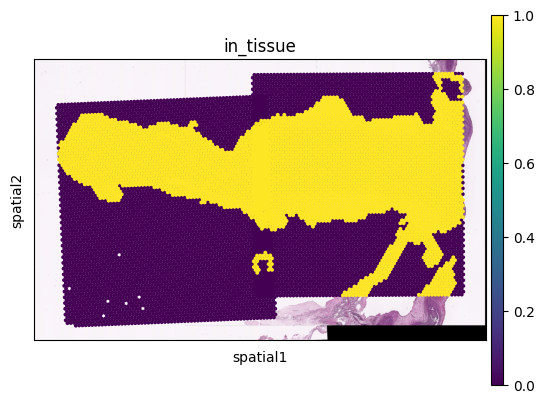

In [35]:
sc.pl.spatial(adata, color="in_tissue")

In [36]:
adata.obs['in_tissue_and_is_overlap'] = np.where((adata.obs['is_overlap'] == 1) & (adata.obs['in_tissue'] == 1), 1, 0)

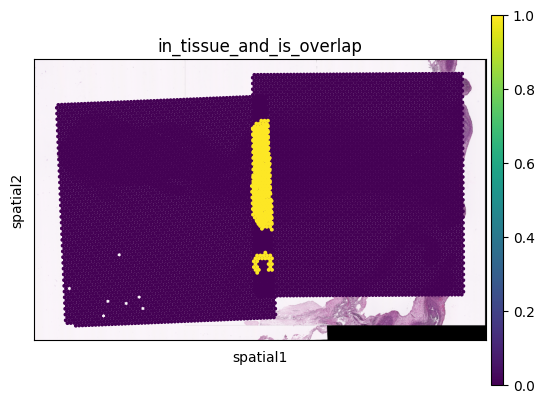

In [37]:
sc.pl.spatial(adata, color="in_tissue_and_is_overlap")

### 4. Save joint anndata object

In [38]:
adata.write('HCA_F_RepTsp13902013_14_joint.h5ad')